# Case Study: Sliding-window glass event detection
构造长音频（背景床 + glass 混入），滑窗推理并做事件级评估。


## 导入与配置
设置路径、模型、混音与评估参数。


In [1]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import soundfile as sf
import torch

sys.path.append("src")

from src.config import AUDIO_DIR, META_FILE, SR, WINDOW_HOP, WINDOW_SECONDS, POSITIVE_LABELS
from src.event_detection import (
    ClipSpec,
    GLASS_LABEL,
    build_background_bed,
    mix_glass_on_bed,
    sliding_log_mel_windows,
    merge_events,
    match_events,
    predict_glass_probs,
)
from src.inference import create_onnx_session, load_torch_checkpoint

# 混音与评估参数
TARGET_BED_DURATION = 60.0  # 背景床时长 (s)
BACKGROUND_GAIN_DB = -8.0   # 背景整体增益
GLASS_GAIN_DB = 0.0         # 玻璃基础增益（叠加前）
START_OFFSET_RANGE = (0.5, 6.0)  # 第一段 glass 起始随机范围 (s)
GAP_RANGE = (-0.5, 8.0)          # glass 之间的随机间隔 (s)，允许轻度重叠
SNR_RANGE_DB = (3.0, 9.0)        # 叠加时玻璃相对背景的目标 SNR
CROSSFADE_MS = 15.0
SPLIT_TOP_DB = 35.0              # 非静音检测阈值，用于真值切分
MIN_EVENT_DUR = 0.08             # 最小事件时长 (s)
THRESHOLD = 0.7
MERGE_GAP = 0.25
TOLERANCE = 0.5
RNG_SEED = 42


## 收集片段并准备背景床
加载外部 glass 片段，采样多段背景，拼接 60s 左右背景床。


In [2]:
EXTERNAL_DIR = Path("data/external")
external_glass_paths = sorted(EXTERNAL_DIR.glob("glass_ext_*"))
if not external_glass_paths:
    raise FileNotFoundError("No external glass clips found under data/external")

glass_specs = [ClipSpec(path=p, label=GLASS_LABEL, gain_db=GLASS_GAIN_DB) for p in external_glass_paths]

meta_df = pd.read_csv(META_FILE)
non_glass_df = meta_df[~meta_df["category"].isin(POSITIVE_LABELS.keys())]
# 多取背景，循环到目标时长
bg_sample_n = max(18, len(glass_specs) * 4)
bg_samples = non_glass_df.sample(n=bg_sample_n, random_state=RNG_SEED, replace=len(non_glass_df) < bg_sample_n)
background_specs = [
    ClipSpec(path=AUDIO_DIR / row["filename"], label="background", gain_db=BACKGROUND_GAIN_DB)
    for _, row in bg_samples.iterrows()
]

for clip in glass_specs:
    print(f"glass  | {clip.path.name}")
print(f"background clips: {len(background_specs)} (sampled)")


glass  | glass_ext_01.wav
glass  | glass_ext_02.flac
glass  | glass_ext_03.wav
glass  | glass_ext_04.wav
glass  | glass_ext_05.wav
background clips: 20 (sampled)


## 构造背景床 (约 60s)
将背景片段交叉淡入淡出拼接成底床。


In [3]:
case_dir = Path("cache/case_study")
case_dir.mkdir(parents=True, exist_ok=True)
mix_path = case_dir / "mix.wav"

background_bed = build_background_bed(
    background_specs,
    sr=SR,
    target_duration=TARGET_BED_DURATION,
    crossfade_ms=CROSSFADE_MS,
    normalize=True,
)
print(f"Background bed duration: {len(background_bed)/SR:.2f}s")


Background bed duration: 60.00s


## 叠加 glass 事件并切分真值
随机顺序与间隔叠加 glass，自动检测片段内的有效击碎段作为真值。


In [4]:
audio, gt_events = mix_glass_on_bed(
    background_bed,
    glass_specs,
    sr=SR,
    start_offset_range=START_OFFSET_RANGE,
    gap_range=GAP_RANGE,
    crossfade_ms=CROSSFADE_MS,
    snr_range_db=SNR_RANGE_DB,
    split_top_db=SPLIT_TOP_DB,
    min_event_dur=MIN_EVENT_DUR,
    seed=RNG_SEED,
)
sf.write(mix_path, audio, SR)

print(f"Mix duration: {len(audio)/SR:.2f}s, saved to {mix_path}")
for ev in gt_events:
    snr_txt = f", SNR={ev.snr_db:.1f}dB" if ev.snr_db is not None else ""
    print(f"GT | {ev.source} | {ev.start:.2f}-{ev.end:.2f}s{snr_txt}")


Mix duration: 60.00s, saved to cache/case_study/mix.wav
GT | glass_ext_05 | 5.22-6.03s, SNR=7.2dB
GT | glass_ext_03 | 9.34-10.25s, SNR=8.9dB
GT | glass_ext_04 | 18.52-19.24s, SNR=7.7dB
GT | glass_ext_04 | 19.26-19.35s, SNR=7.7dB
GT | glass_ext_02 | 20.44-20.91s, SNR=5.7dB
GT | glass_ext_01 | 24.70-25.23s, SNR=8.6dB
GT | glass_ext_01 | 25.35-25.44s, SNR=8.6dB
GT | glass_ext_01 | 25.46-25.58s, SNR=8.6dB
GT | glass_ext_01 | 27.16-27.74s, SNR=8.6dB
GT | glass_ext_01 | 27.83-28.11s, SNR=8.6dB
GT | glass_ext_01 | 29.66-30.22s, SNR=8.6dB
GT | glass_ext_01 | 30.25-30.34s, SNR=8.6dB
GT | glass_ext_01 | 30.36-30.59s, SNR=8.6dB


## 试听混音并查看真值时间
播放拼接后的长音频，并列出每个 glass 片段的起止时间。


In [5]:
from IPython.display import Audio, display

print(f"Mix duration: {len(audio)/SR:.2f}s (saved at {mix_path})")
print("Ground truth glass events:")
for ev in gt_events:
    snr_txt = f" (SNR={ev.snr_db:.1f}dB)" if ev.snr_db is not None else ""
    print(f"  - {ev.source}: {ev.start:.2f}-{ev.end:.2f}s{snr_txt}")

display(Audio(str(mix_path), rate=SR))


Mix duration: 60.00s (saved at cache/case_study/mix.wav)
Ground truth glass events:
  - glass_ext_05: 5.22-6.03s (SNR=7.2dB)
  - glass_ext_03: 9.34-10.25s (SNR=8.9dB)
  - glass_ext_04: 18.52-19.24s (SNR=7.7dB)
  - glass_ext_04: 19.26-19.35s (SNR=7.7dB)
  - glass_ext_02: 20.44-20.91s (SNR=5.7dB)
  - glass_ext_01: 24.70-25.23s (SNR=8.6dB)
  - glass_ext_01: 25.35-25.44s (SNR=8.6dB)
  - glass_ext_01: 25.46-25.58s (SNR=8.6dB)
  - glass_ext_01: 27.16-27.74s (SNR=8.6dB)
  - glass_ext_01: 27.83-28.11s (SNR=8.6dB)
  - glass_ext_01: 29.66-30.22s (SNR=8.6dB)
  - glass_ext_01: 30.25-30.34s (SNR=8.6dB)
  - glass_ext_01: 30.36-30.59s (SNR=8.6dB)


## 生成滑窗 mel 批次
使用训练同参 (1s/0.5s) 转换为 log-mel。


In [6]:
batch, spans = sliding_log_mel_windows(
    audio,
    sr=SR,
    window_seconds=WINDOW_SECONDS,
    hop_seconds=WINDOW_HOP,
    min_coverage=0.7,
)
print(f"Windows: {len(spans)}, batch shape: {tuple(batch.shape)}")


Windows: 119, batch shape: (119, 1, 64, 87)


## Torch 与 ONNX 推理
批量前向得到每窗 glass 概率，并比对 Torch/ONNX。


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ckpt_path = Path("cache/experiments/tinyglassnet_best.pt")
onnx_path = Path("cache/experiments/tinyglassnet_best.onnx")

model, _ = load_torch_checkpoint(ckpt_path, device=device)
torch_probs, torch_result = predict_glass_probs(batch, spans, model=model, device=device)

onnx_probs = None
max_delta = None
if onnx_path.exists():
    onnx_sess = create_onnx_session(onnx_path)
    onnx_probs, onnx_result = predict_glass_probs(batch, spans, session=onnx_sess, device="cpu")
    max_delta = float(np.max(np.abs(np.array(torch_probs) - np.array(onnx_probs))))

print(f"Torch probs range: {min(torch_probs):.3f}–{max(torch_probs):.3f}")
if onnx_probs is not None:
    print(f"ONNX probs range: {min(onnx_probs):.3f}–{max(onnx_probs):.3f}, max delta {max_delta:.4f}")


Torch probs range: 0.008–1.000
ONNX probs range: 0.008–1.000, max delta 0.0000


## 合并窗口并评估事件
阈值合并窗口，允许 ±0.5s 偏移匹配，输出 P/R/F1。


In [8]:
pred_events = merge_events(spans, torch_probs, threshold=THRESHOLD, merge_gap=MERGE_GAP)
metrics = match_events(pred_events, gt_events, tolerance=TOLERANCE)

print("Predicted events:")
for ev in pred_events:
    print(f"pred | {ev['start']:.2f}-{ev['end']:.2f}s | max_prob={ev['max_prob']:.3f}")
    
print("Ground truth events:")
for ev in gt_events:
    snr_txt = f" (SNR={ev.snr_db:.1f}dB)" if ev.snr_db is not None else ""
    print(f"gt   | {ev.start:.2f}-{ev.end:.2f}s | {ev.source}{snr_txt}")
    
print(f"TP={metrics['tp']} FP={metrics['fp']} FN={metrics['fn']} P={metrics['precision']:.3f} R={metrics['recall']:.3f} F1={metrics['f1']:.3f}")


Predicted events:
pred | 4.50-6.00s | max_prob=0.925
pred | 9.00-11.00s | max_prob=0.950
pred | 15.00-16.00s | max_prob=0.797
pred | 16.50-17.50s | max_prob=0.881
pred | 18.00-19.50s | max_prob=0.863
pred | 20.00-21.50s | max_prob=0.996
pred | 24.00-26.00s | max_prob=1.000
pred | 26.50-28.50s | max_prob=1.000
pred | 29.00-30.50s | max_prob=0.997
pred | 49.00-50.50s | max_prob=0.926
Ground truth events:
gt   | 5.22-6.03s | glass_ext_05 (SNR=7.2dB)
gt   | 9.34-10.25s | glass_ext_03 (SNR=8.9dB)
gt   | 18.52-19.24s | glass_ext_04 (SNR=7.7dB)
gt   | 19.26-19.35s | glass_ext_04 (SNR=7.7dB)
gt   | 20.44-20.91s | glass_ext_02 (SNR=5.7dB)
gt   | 24.70-25.23s | glass_ext_01 (SNR=8.6dB)
gt   | 25.35-25.44s | glass_ext_01 (SNR=8.6dB)
gt   | 25.46-25.58s | glass_ext_01 (SNR=8.6dB)
gt   | 27.16-27.74s | glass_ext_01 (SNR=8.6dB)
gt   | 27.83-28.11s | glass_ext_01 (SNR=8.6dB)
gt   | 29.66-30.22s | glass_ext_01 (SNR=8.6dB)
gt   | 30.25-30.34s | glass_ext_01 (SNR=8.6dB)
gt   | 30.36-30.59s | glass_ext_0

## 概率时间轴可视化
画出概率柱状并标记 GT 与预测事件。


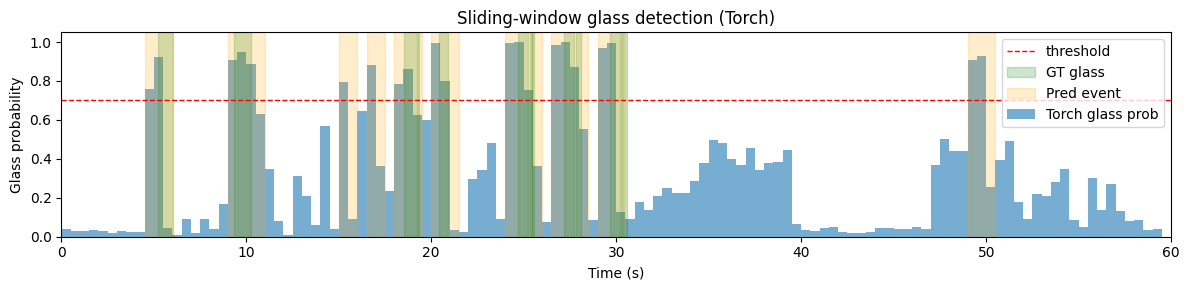

In [9]:
import matplotlib.pyplot as plt

starts = [s for s, _ in spans]
fig, ax = plt.subplots(figsize=(12, 3))
ax.bar(starts, torch_probs, width=WINDOW_HOP, align="edge", alpha=0.6, label="Torch glass prob")
ax.axhline(THRESHOLD, color="red", linestyle="--", linewidth=1, label="threshold")

gt_label_used = False
for ev in gt_events:
    ax.axvspan(ev.start, ev.end, color="green", alpha=0.2, label="GT glass" if not gt_label_used else None)
    gt_label_used = True
pred_label_used = False
for ev in pred_events:
    ax.axvspan(ev["start"], ev["end"], color="orange", alpha=0.2, label="Pred event" if not pred_label_used else None)
    pred_label_used = True

ax.set_xlabel("Time (s)")
ax.set_ylabel("Glass probability")
ax.set_title("Sliding-window glass detection (Torch)")
ax.legend(loc="upper right")
ax.set_xlim(0, spans[-1][1] if spans else 1.0)
ax.set_ylim(0, 1.05)
plt.tight_layout()
